In [1]:
import pandas as pd
import numpy as np
from pulp import *
import os
import pulp as lp
# import cplex
# # from cplex import Cplex
# # from cplex.exceptions import CplexError


C:\Users\Anu Zan\AppData\Local\Temp\ipykernel_24008\592519910.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import sys
sys.path.append(r"C:\\Program Files\\IBM\\ILOG\\CPLEX_Studio2211\\python\setup.py install")  # Update the path with your actual path



In [3]:
##Load datasets

# Change the working directory to the notebook's directory
notebook_dir = "C:\\Users\\Anu Zan\\Desktop\\GeorgiaTech Spring 2024\\ISYE 6740 CDA\\project"
os.chdir(notebook_dir)

# Now, define the relative path to the dataset
dataset_path = os.path.join("..", "Dataset")

Optimization_dataset=pd.read_csv(os.path.join(dataset_path, "OptimizationData_04012024.csv"))
Intervention_dataset=pd.read_csv(os.path.join(dataset_path,"InterventionData_04052024.csv"))

#removed last column(P_NOTX) since it does not appear in the intervention dataset
#Household_dataset=Household_dataset.iloc[:, :-1]

In [4]:
## Data cleaning and conversions to datetype
Optimization_dataset['intervention_eligibility_start'] = pd.to_datetime(Optimization_dataset['intervention_eligibility_start'])
Optimization_dataset['intervention_eligibility_end'] = pd.to_datetime(Optimization_dataset['intervention_eligibility_end'])
Intervention_dataset['EnrollmentDate'] = pd.to_datetime(Intervention_dataset['EnrollmentDate'])
Optimization_dataset

,Unnamed: 0,ID,intervention_eligibility_start,intervention_eligibility_end,subpopulation,P_RRH,P_TSH,P_PSH,P_NOTX
0,0,5346,2020-08-12,2020-11-12,0,0.403523,0.365126,0.317578,0.038237
1,1,10810,2020-06-14,2020-09-14,1,0.486524,0.312525,0.308390,0.086466
2,2,13875,2021-07-25,2022-11-08,0,0.390293,0.380058,0.247997,0.040080
3,3,13440,2020-06-20,2021-08-21,0,0.343476,0.388433,0.295636,0.026810
4,4,11434,2020-06-17,2020-09-17,1,0.340353,0.415589,0.271931,0.026012
...,...,...,...,...,...,...,...,...,...
20676,20890,257,2020-06-10,2022-03-09,1,0.614422,0.373384,0.398029,0.238472
20677,20891,257,2022-11-09,2023-01-03,1,0.563452,0.379900,0.383452,0.252566
20678,20892,12780,2020-06-21,2020-09-21,1,0.483045,0.375423,0.282675,0.034415
20679,20893,2256,2020-06-09,2020-09-09,1,0.495911,0.397076,0.272658,0.052616


In [5]:
## Remove rows where intervention ends in 2023
Training_Optimization_dataset=Optimization_dataset[Optimization_dataset['intervention_eligibility_end'] < "2021-12-31"]
Training_intervention_dataset=Intervention_dataset[Intervention_dataset['EnrollmentDate']< "2021-12-31" ]


In [6]:
## Groupe intervention type per week 
Training_intervention_dataset.sort_values('EnrollmentDate', inplace=True)
Training_intervention_dataset_grouped=Training_intervention_dataset.groupby([pd.Grouper(key='EnrollmentDate', freq='W'), 'ProjectTypeName']).size().unstack(fill_value=0)
# Create a new row as a DataFrame with the correct datetime index directly
new_row_index = pd.DatetimeIndex([pd.to_datetime('2017-01-01')])
new_row = pd.DataFrame({'PH - Permanent Supportive Housing': [0],
                        'PH - Rapid Re-Housing': [0],
                        'Transitional Housing': [0]},
                       index=new_row_index)

# Concatenate the new_row DataFrame with the existing grouped DataFrame
# Since your grouped DataFrame has a datetime index (EnrollmentDate), ensure the new row also does
Training_intervention_dataset_grouped = pd.concat([new_row, Training_intervention_dataset_grouped])

# Since concatenation can mess up the chronological order, sort by index just in case
Training_intervention_dataset_grouped.sort_index(inplace=True)

# Check to ensure the new row is added correctly
Training_intervention_dataset_grouped.head().dropna()
int

C:\Users\Anu Zan\AppData\Local\Temp\ipykernel_24008\2728604530.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Training_intervention_dataset.sort_values('EnrollmentDate', inplace=True)


int

In [7]:
Training_Optimization_dataset.sort_values('intervention_eligibility_start', inplace=True)

# Now, grouping by week and applying the provided lambda function to reset index within each group, but ensuring 'Week_Start_Date' is preserved
Training_Optimization_dataset_grouped = Training_Optimization_dataset.set_index("intervention_eligibility_start").groupby(pd.Grouper(freq='W')).apply(lambda _df: _df.assign(Week_Start=_df.name)).reset_index(drop=True)

# The 'Week_Start' column now contains the start of the week for the 'intervention_eligibility_start' date
Training_Optimization_dataset_grouped.dropna()
Training_Optimization_dataset_grouped=Training_Optimization_dataset_grouped[Training_Optimization_dataset_grouped['Week_Start']< '12-31-2021']
Training_Optimization_dataset_grouped

C:\Users\Anu Zan\AppData\Local\Temp\ipykernel_24008\2551345844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Training_Optimization_dataset.sort_values('intervention_eligibility_start', inplace=True)


,Unnamed: 0,ID,intervention_eligibility_end,subpopulation,P_RRH,P_TSH,P_PSH,P_NOTX,Week_Start
0,7681,13861,2017-03-31,1,0.605708,0.392315,0.390282,0.081395,2017-01-01
1,18382,12417,2017-04-01,1,0.384913,0.323653,0.331396,0.078390,2017-01-01
2,8521,5981,2018-10-03,1,0.387764,0.385844,0.360858,0.066253,2017-01-08
3,19079,9994,2017-06-28,1,0.364034,0.396487,0.285617,0.032998,2017-01-08
4,18327,4867,2017-10-23,1,0.459237,0.369800,0.362774,0.101124,2017-01-08
...,...,...,...,...,...,...,...,...,...
13392,2663,15418,2021-12-15,1,0.497024,0.402138,0.257841,0.050518,2021-12-12
13393,2690,10428,2021-12-18,0,0.279535,0.439259,0.337689,0.030370,2021-12-19
13394,2695,901,2021-12-25,1,0.505599,0.449058,0.306092,0.081206,2021-12-19
13395,18938,6271,2021-12-22,1,0.491370,0.262897,0.287299,0.054514,2021-12-19


In [8]:
## Mapping 2 datasets on intervention type
intervention_mapping = {
    'PH - Rapid Re-Housing': 'P_RRH',
    'Transitional Housing': 'P_TSH',
    'PH - Permanent Supportive Housing': 'P_PSH',
    #  P_NOTX 
}

In [9]:
intervention_types = ['PH - Permanent Supportive Housing', 'PH - Rapid Re-Housing', 'Transitional Housing']

In [10]:
# Initialize the problem
prob = lp.LpProblem("Housing_Intervention_Optimization", lp.LpMaximize)

In [11]:
household_ids = Training_Optimization_dataset_grouped['ID'].unique()
intervention_types = ['PH - Permanent Supportive Housing', 'PH - Rapid Re-Housing', 'Transitional Housing']  # Assuming these are your interventions
weeks = Training_Optimization_dataset_grouped['Week_Start'].dt.strftime('%Y-%m-%d').unique()


In [12]:
Training_intervention_dataset_grouped

,PH - Permanent Supportive Housing,PH - Rapid Re-Housing,Transitional Housing
2017-01-01,0,0,0
2017-01-08,1,1,0
2017-01-15,0,2,0
2017-01-22,0,2,0
2017-02-05,0,1,0
...,...,...,...
2021-11-28,0,1,0
2021-12-05,1,1,0
2021-12-12,0,1,0
2021-12-19,0,1,2


In [13]:
weeks

array(['2017-01-01', '2017-01-08', '2017-01-15', '2017-01-22',
       '2017-01-29', '2017-02-05', '2017-02-12', '2017-02-19',
       '2017-02-26', '2017-03-05', '2017-03-12', '2017-03-19',
       '2017-03-26', '2017-04-02', '2017-04-09', '2017-04-16',
       '2017-04-23', '2017-04-30', '2017-05-07', '2017-05-14',
       '2017-05-21', '2017-05-28', '2017-06-04', '2017-06-11',
       '2017-06-18', '2017-06-25', '2017-07-02', '2017-07-09',
       '2017-07-16', '2017-07-23', '2017-07-30', '2017-08-06',
       '2017-08-13', '2017-08-20', '2017-08-27', '2017-09-03',
       '2017-09-10', '2017-09-17', '2017-09-24', '2017-10-01',
       '2017-10-08', '2017-10-15', '2017-10-22', '2017-10-29',
       '2017-11-05', '2017-11-12', '2017-11-19', '2017-11-26',
       '2017-12-03', '2017-12-10', '2017-12-17', '2017-12-24',
       '2017-12-31', '2018-01-07', '2018-01-14', '2018-01-21',
       '2018-01-28', '2018-02-04', '2018-02-11', '2018-02-18',
       '2018-02-25', '2018-03-04', '2018-03-11', '2018-

In [50]:
# Define decision variables
x = LpVariable.dicts("Assignment", 
                     [(i, j, t) for i in household_ids 
                                  for j in intervention_types 
                                  for t in weeks], cat='Binary')



KeyboardInterrupt



In [15]:
probabilities = {}
for index, row in Training_Optimization_dataset_grouped.iterrows():
    week_str = row['Week_Start'].strftime('%Y-%m-%d')
    
    # Check if the week exists in the Training_intervention_dataset_grouped DataFrame
    if week_str in Training_intervention_dataset_grouped.index:
        # Access the row for the specific week, which gives a Series with intervention capacities
        available_interventions = Training_intervention_dataset_grouped.loc[week_str]
        
        # Iterate through the intervention mapping to assign probabilities
        for intervention, p_intervention in intervention_mapping.items():
            # Check directly if the intervention has a non-zero capacity for the week
            # The 'get' method on Series is used to safely attempt to access an intervention, returning None if not found
            if available_interventions.get(intervention, 0) > 0:
                # Check if the probability value exists and is non-negative
                if pd.notnull(row[p_intervention]):
                    # Assign the probability to the dictionary
                    probabilities[(row['ID'], intervention, week_str)] = row[p_intervention]


In [16]:
probabilities 

{(5981, 'PH - Rapid Re-Housing', '2017-01-08'): 0.3877637417636208,
 (5981, 'PH - Permanent Supportive Housing', '2017-01-08'): 0.360857620938829,
 (9994, 'PH - Rapid Re-Housing', '2017-01-08'): 0.364033611625594,
 (9994, 'PH - Permanent Supportive Housing', '2017-01-08'): 0.2856171371616515,
 (4867, 'PH - Rapid Re-Housing', '2017-01-08'): 0.4592371047897797,
 (4867, 'PH - Permanent Supportive Housing', '2017-01-08'): 0.3627736540996712,
 (11516, 'PH - Rapid Re-Housing', '2017-01-08'): 0.5132157230996602,
 (11516,
  'PH - Permanent Supportive Housing',
  '2017-01-08'): 0.2697711391526141,
 (15823, 'PH - Rapid Re-Housing', '2017-01-08'): 0.2891406306892777,
 (15823,
  'PH - Permanent Supportive Housing',
  '2017-01-08'): 0.2952944096649059,
 (618, 'PH - Rapid Re-Housing', '2017-01-08'): 0.5119365997053356,
 (618, 'PH - Permanent Supportive Housing', '2017-01-08'): 0.3204713463818098,
 (1593, 'PH - Rapid Re-Housing', '2017-01-08'): 0.4788642465276124,
 (1593, 'PH - Permanent Supportive H

In [17]:
# Define the objective function
prob += lp.lpSum([probabilities[(i, j, t)] * x[(i, j, t)]
                  for i in household_ids 
                  for j in intervention_types 
                  for t in weeks 
                  if (i, j, t) in probabilities]), "Total_Probability_of_Exiting_Homelessness"


In [18]:
# Building the capacities dictionary
capacities = {}
for t, row in Training_intervention_dataset_grouped.iterrows():
    week_str = t.strftime('%Y-%m-%d')
    for j in intervention_types:  
        capacities[(j, week_str)] = row[j]

In [19]:
# Capacity Constraints
for j in intervention_types:  
    for week_str in weeks:
        if (j, week_str) in capacities:  # Ensure the capacity data exists for this intervention and week
            prob += lp.lpSum(x[(i, j, week_str)] for i in household_ids) <= capacities[(j, week_str)], f"Capacity_{j}_{week_str}"



In [20]:
# Additional binary decision variables for each household and week
assigned_up_to_week = LpVariable.dicts("AssignedUpToWeek", 
                                       [(i, t) for i in household_ids for t in weeks], 
                                       cat='Binary')

# Single Assignment for Each Household
for i in household_ids:
    prob += lp.lpSum(assigned_up_to_week[(i, t)] for t in weeks) <= 1, f"Single_Assignment_{i}"



In [21]:
for i in household_ids:
    for week_idx, t in enumerate(weeks):
        # If assigned this week or any previous week, then no further assignments
        prob += assigned_up_to_week[(i, t)] >= lp.lpSum(x[(i, j, t)] for j in intervention_types), f"Assign_This_Week_{i}_{t}"

In [22]:
prob.solve(pulp.PULP_CBC_CMD(presolve=1, msg=True))

1

In [23]:
# Check the status of the solution
print("Solution Status:", LpStatus[prob.status])

# Print the objective function value (total probability of exiting homelessness)
print("Total Probability of Exiting Homelessness:", value(prob.objective))

# Iterate through the decision variables and safely print non-zero assignments
for variable in prob.variables():
    if variable.varValue is not None and variable.varValue > 0:
        print(variable.name, "=", variable.varValue)


Solution Status: Optimal
Total Probability of Exiting Homelessness: 464.526690769765


AssignedUpToWeek_(0,_'2021_02_28') = 1.0
AssignedUpToWeek_(10000,_'2017_08_13') = 1.0
AssignedUpToWeek_(10001,_'2019_03_17') = 1.0
AssignedUpToWeek_(10002,_'2019_01_27') = 1.0
AssignedUpToWeek_(10003,_'2019_03_17') = 1.0
AssignedUpToWeek_(10004,_'2021_08_08') = 1.0
AssignedUpToWeek_(10005,_'2020_10_18') = 1.0
AssignedUpToWeek_(10007,_'2020_08_16') = 1.0
AssignedUpToWeek_(10008,_'2020_01_19') = 1.0
AssignedUpToWeek_(10009,_'2017_03_26') = 1.0
AssignedUpToWeek_(10010,_'2021_02_07') = 1.0
AssignedUpToWeek_(10014,_'2020_04_19') = 1.0
AssignedUpToWeek_(10015,_'2017_02_26') = 1.0
AssignedUpToWeek_(10017,_'2020_08_02') = 1.0
AssignedUpToWeek_(1002,_'2020_09_06') = 1.0
AssignedUpToWeek_(10021,_'2017_07_16') = 1.0
AssignedUpToWeek_(10023,_'2020_04_26') = 1.0
AssignedUpToWeek_(10024,_'2019_03_17') = 1.0
AssignedUpToWeek_(10025,_'2020_02_16') = 1.0
AssignedUpToWeek_(10027,_'2018_01_21') = 1.0
AssignedUpToWeek_(10028,_'2019_01_27') = 1.0
AssignedUpToWeek_(1003,_'2017_01_15') = 1.0
AssignedUpToWeek

In [24]:
# Initialize a list to hold formatted variable names with values
variable_names = []

# Iterate through the decision variables and filter based on your criteria
for variable in prob.variables():
    if variable.varValue is not None and variable.varValue > 0:
        # Check if the variable name starts with 'Assignment_'
        if variable.name.startswith("Assignment_"):
            formatted_variable = f"{variable.name} = {variable.varValue}"
            variable_names.append(formatted_variable)

# Now variable_names contains the formatted strings of all relevant assignments
print(variable_names)

["Assignment_(10003,_'PH___Rapid_Re_Housing',_'2019_03_17') = 1.0", "Assignment_(10007,_'PH___Rapid_Re_Housing',_'2020_08_16') = 1.0", "Assignment_(10009,_'PH___Rapid_Re_Housing',_'2017_03_26') = 1.0", "Assignment_(10010,_'PH___Rapid_Re_Housing',_'2021_02_07') = 1.0", "Assignment_(10025,_'PH___Rapid_Re_Housing',_'2020_02_16') = 1.0", "Assignment_(10030,_'PH___Permanent_Supportive_Housing',_'2019_07_14') = 1.0", "Assignment_(10064,_'PH___Rapid_Re_Housing',_'2021_01_17') = 1.0", "Assignment_(10070,_'PH___Permanent_Supportive_Housing',_'2019_06_30') = 1.0", "Assignment_(10076,_'PH___Rapid_Re_Housing',_'2017_11_05') = 1.0", "Assignment_(10086,_'PH___Rapid_Re_Housing',_'2018_01_28') = 1.0", "Assignment_(10100,_'PH___Rapid_Re_Housing',_'2019_06_16') = 1.0", "Assignment_(10105,_'PH___Permanent_Supportive_Housing',_'2021_03_14') = 1.0", "Assignment_(10109,_'PH___Rapid_Re_Housing',_'2020_03_29') = 1.0", "Assignment_(10124,_'PH___Rapid_Re_Housing',_'2020_12_13') = 1.0", "Assignment_(10135,_'PH__

In [25]:
variable_names

["Assignment_(10003,_'PH___Rapid_Re_Housing',_'2019_03_17') = 1.0",
 "Assignment_(10007,_'PH___Rapid_Re_Housing',_'2020_08_16') = 1.0",
 "Assignment_(10009,_'PH___Rapid_Re_Housing',_'2017_03_26') = 1.0",
 "Assignment_(10010,_'PH___Rapid_Re_Housing',_'2021_02_07') = 1.0",
 "Assignment_(10025,_'PH___Rapid_Re_Housing',_'2020_02_16') = 1.0",
 "Assignment_(10030,_'PH___Permanent_Supportive_Housing',_'2019_07_14') = 1.0",
 "Assignment_(10064,_'PH___Rapid_Re_Housing',_'2021_01_17') = 1.0",
 "Assignment_(10070,_'PH___Permanent_Supportive_Housing',_'2019_06_30') = 1.0",
 "Assignment_(10076,_'PH___Rapid_Re_Housing',_'2017_11_05') = 1.0",
 "Assignment_(10086,_'PH___Rapid_Re_Housing',_'2018_01_28') = 1.0",
 "Assignment_(10100,_'PH___Rapid_Re_Housing',_'2019_06_16') = 1.0",
 "Assignment_(10105,_'PH___Permanent_Supportive_Housing',_'2021_03_14') = 1.0",
 "Assignment_(10109,_'PH___Rapid_Re_Housing',_'2020_03_29') = 1.0",
 "Assignment_(10124,_'PH___Rapid_Re_Housing',_'2020_12_13') = 1.0",
 "Assignment

In [26]:
def clean_variable_name(name):
    # Split the name by commas
    parts = name.split(",")
    # Extract data
    number = parts[0].split("_(")[1].strip()
    # Remove quotes, underscores, and leading/trailing whitespaces from housing type
    housing_type = parts[1].strip().strip("'").replace("_", " ").replace("'", "")
    # Extract date, remove unwanted characters, and clean it (replace underscores with hyphens)
    date = parts[2].split(")")[0].strip().strip("'").replace("_", "-").replace("-'", "")
    return pd.Series({"Assignment_ID": number, "Housing_Type": housing_type, "Assignment_Date": date})

# Clean variable names using the function
Optimization_initial_result_df = pd.DataFrame([clean_variable_name(name) for name in variable_names])
Optimization_initial_result_df['Assignment_Date']=pd.to_datetime(Optimization_initial_result_df['Assignment_Date'])
Optimization_initial_result_df=Optimization_initial_result_df.sort_values(by='Assignment_Date')


# Print the cleaned DataFrame to verify results
print(Optimization_initial_result_df.head())


    Assignment_ID                        Housing_Type Assignment_Date
122         12455               PH   Rapid Re Housing      2017-01-08
522          4621   PH   Permanent Supportive Housing      2017-01-08
346         16747               PH   Rapid Re Housing      2017-01-15
478          3771               PH   Rapid Re Housing      2017-01-15
430          2951               PH   Rapid Re Housing      2017-01-22


In [27]:
## Add subpopulation
Optimization_initial_result_df['Assignment_ID']=Optimization_initial_result_df['Assignment_ID'].astype(int)
Training_Optimization_dataset_grouped['ID']=Training_Optimization_dataset_grouped['ID'].astype(int)

Optimization_subp_result_df=pd.merge(Optimization_initial_result_df, Training_Optimization_dataset_grouped, left_on='Assignment_ID', right_on='ID', how='left')
Optimization_subp_result_df.drop(columns=['Assignment_ID','intervention_eligibility_end','P_RRH','P_TSH','P_PSH','P_NOTX','Week_Start','Unnamed: 0'], inplace=True)
Optimization_subp_result_df = Optimization_subp_result_df[['ID', 'Housing_Type', 'subpopulation', 'Assignment_Date']]

# Display the rearranged DataFrame to verify the new column order
print(Optimization_subp_result_df.head())


      ID                        Housing_Type  subpopulation Assignment_Date
0  12455               PH   Rapid Re Housing              0      2017-01-08
1   4621   PH   Permanent Supportive Housing              0      2017-01-08
2  16747               PH   Rapid Re Housing              0      2017-01-15
3   3771               PH   Rapid Re Housing              0      2017-01-15
4   2951               PH   Rapid Re Housing              1      2017-01-22


In [28]:
# Count the number of 0s and 1s in the subpopulation column
count_0 = (Optimization_subp_result_df['subpopulation'] == 0).sum()
count_1 = (Optimization_subp_result_df['subpopulation'] == 1).sum()

# Calculate the proportion of 0s over 1s
if count_1 != 0:  # Prevent division by zero
    percentage = count_0 / (count_1 + count_0)
else:
    percentage = None  # Indicates no 1s are present to calculate the ratio

# Output the proportion
print("Percentage of  female getting rehousing is", percentage)
print("Percentage of  Male getting rehousing is", 1 -percentage)



Percentage of  female getting rehousing is 0.581140350877193
Percentage of  Male getting rehousing is 0.41885964912280704


In [29]:
grouped = Optimization_subp_result_df.groupby(['subpopulation', 'Assignment_Date']).size().reset_index(name='Count')
# Create pivot table with Assignment_Date as index, subpopulation categories as columns
# Create pivot table with Assignment_Date as index, subpopulation categories as columns
pivot_df = grouped.pivot_table(index='Assignment_Date', columns='subpopulation', values='Count', aggfunc='sum', fill_value=0)

# Rename the columns for clarity
pivot_df.columns = ['female', 'male']

# Sum the total assignments for the week
pivot_df['total_assignment'] = pivot_df.sum(axis=1)

# Reset the index to make Assignment_Date a column again
pivot_df.reset_index(inplace=True)

# Calculate cumulative sums for each category
pivot_df['cumulative_male'] = pivot_df['male'].cumsum()
pivot_df['cumulative_female'] = pivot_df['female'].cumsum()
pivot_df['cumulative_total'] = pivot_df['total_assignment'].cumsum()
pivot_df['Gamma_male']=pivot_df['cumulative_male']/pivot_df['cumulative_total']
pivot_df['Gamma_Female']=pivot_df['cumulative_female']/pivot_df['cumulative_total']
pivot_df['Alpha_male'] = 0.442
pivot_df['Alpha_female'] = 0.558
pivot_df['Egt_male']=pivot_df['Gamma_male']/pivot_df['Alpha_male'] 
pivot_df['Egt_female']=pivot_df['Gamma_Female']/pivot_df['Alpha_female'] 
pivot_df['R_male']=pivot_df['Egt_male']/pivot_df['Egt_female']
pivot_df['R_female']=pivot_df['Egt_female']/pivot_df['Egt_male']

pivot_df['Male_penalty']=1-pivot_df['R_male']


pivot_df=pivot_df.drop(columns=['male', 'female', 'total_assignment'])

# Display the final DataFrame with cumulative sums
pivot_df.head()

,Assignment_Date,cumulative_male,cumulative_female,cumulative_total,Gamma_male,Gamma_Female,Alpha_male,Alpha_female,Egt_male,Egt_female,R_male,R_female,Male_penalty
0,2017-01-08,0,2,2,0.000000,1.000000,0.442,0.558,0.000000,1.792115,0.000000,inf,1.000000
1,2017-01-15,0,4,4,0.000000,1.000000,0.442,0.558,0.000000,1.792115,0.000000,inf,1.000000
2,2017-01-22,2,4,6,0.333333,0.666667,0.442,0.558,0.754148,1.194743,0.631222,1.584229,0.368778
3,2017-02-05,2,5,7,0.285714,0.714286,0.442,0.558,0.646412,1.280082,0.504977,1.980287,0.495023
4,2017-02-12,3,8,11,0.272727,0.727273,0.442,0.558,0.617030,1.303356,0.473416,2.112306,0.526584


In [30]:
pivot_df_r_male=pivot_df[['Assignment_Date','R_male']]
new_row = pd.DataFrame({'Assignment_Date': [pd.to_datetime('2017-01-01')], 'R_male': [0]})
pivot_df_r_male = pd.concat([new_row, pivot_df_r_male], ignore_index=True)
pivot_df_r_male.sort_values(by='Assignment_Date', inplace=True)
pivot_df_r_male.reset_index(drop=True, inplace=True)
pivot_df_r_male


,Assignment_Date,R_male
0,2017-01-01,0.000000
1,2017-01-08,0.000000
2,2017-01-15,0.000000
3,2017-01-22,0.631222
4,2017-02-05,0.504977
...,...,...
245,2021-11-28,0.894231
246,2021-12-05,0.894927
247,2021-12-12,0.897313
248,2021-12-19,0.907530


In [31]:
Training_Optimization_dataset_grouped

,Unnamed: 0,ID,intervention_eligibility_end,subpopulation,P_RRH,P_TSH,P_PSH,P_NOTX,Week_Start
0,7681,13861,2017-03-31,1,0.605708,0.392315,0.390282,0.081395,2017-01-01
1,18382,12417,2017-04-01,1,0.384913,0.323653,0.331396,0.078390,2017-01-01
2,8521,5981,2018-10-03,1,0.387764,0.385844,0.360858,0.066253,2017-01-08
3,19079,9994,2017-06-28,1,0.364034,0.396487,0.285617,0.032998,2017-01-08
4,18327,4867,2017-10-23,1,0.459237,0.369800,0.362774,0.101124,2017-01-08
...,...,...,...,...,...,...,...,...,...
13392,2663,15418,2021-12-15,1,0.497024,0.402138,0.257841,0.050518,2021-12-12
13393,2690,10428,2021-12-18,0,0.279535,0.439259,0.337689,0.030370,2021-12-19
13394,2695,901,2021-12-25,1,0.505599,0.449058,0.306092,0.081206,2021-12-19
13395,18938,6271,2021-12-22,1,0.491370,0.262897,0.287299,0.054514,2021-12-19


In [32]:
# Print unique weeks in both datasets to see if there are missing weeks in pivot_df_r_male
print("Unique weeks in optimization dataset:", Training_Optimization_dataset_grouped['Week_Start'].dt.strftime('%Y-%m-%d').unique())
print("Date range in R_male dataset:", pivot_df_r_male.index.unique())

# If pivot_df_r_male does not cover all dates, decide on a strategy to fill these.
# For example, forward fill:
#pivot_df_r_male = pivot_df_r_male.reindex(pd.date_range(start=pivot_df_r_male.index.min(), 
                                                        #end=Training_Optimization_dataset_grouped['Week_Start'].max(), 
                                                        #freq='W')).fillna(method='ffill')


Unique weeks in optimization dataset: ['2017-01-01' '2017-01-08' '2017-01-15' '2017-01-22' '2017-01-29'
 '2017-02-05' '2017-02-12' '2017-02-19' '2017-02-26' '2017-03-05'
 '2017-03-12' '2017-03-19' '2017-03-26' '2017-04-02' '2017-04-09'
 '2017-04-16' '2017-04-23' '2017-04-30' '2017-05-07' '2017-05-14'
 '2017-05-21' '2017-05-28' '2017-06-04' '2017-06-11' '2017-06-18'
 '2017-06-25' '2017-07-02' '2017-07-09' '2017-07-16' '2017-07-23'
 '2017-07-30' '2017-08-06' '2017-08-13' '2017-08-20' '2017-08-27'
 '2017-09-03' '2017-09-10' '2017-09-17' '2017-09-24' '2017-10-01'
 '2017-10-08' '2017-10-15' '2017-10-22' '2017-10-29' '2017-11-05'
 '2017-11-12' '2017-11-19' '2017-11-26' '2017-12-03' '2017-12-10'
 '2017-12-17' '2017-12-24' '2017-12-31' '2018-01-07' '2018-01-14'
 '2018-01-21' '2018-01-28' '2018-02-04' '2018-02-11' '2018-02-18'
 '2018-02-25' '2018-03-04' '2018-03-11' '2018-03-18' '2018-03-25'
 '2018-04-01' '2018-04-08' '2018-04-15' '2018-04-22' '2018-04-29'
 '2018-05-06' '2018-05-13' '2018-05-20

In [33]:
# Training_Optimization_dataset_grouped_with_r=Training_Optimization_dataset_grouped.copy()

# Training_Optimization_dataset_grouped_with_r

,Unnamed: 0,ID,intervention_eligibility_end,subpopulation,P_RRH,P_TSH,P_PSH,P_NOTX,Week_Start
0,7681,13861,2017-03-31,1,0.605708,0.392315,0.390282,0.081395,2017-01-01
1,18382,12417,2017-04-01,1,0.384913,0.323653,0.331396,0.078390,2017-01-01
2,8521,5981,2018-10-03,1,0.387764,0.385844,0.360858,0.066253,2017-01-08
3,19079,9994,2017-06-28,1,0.364034,0.396487,0.285617,0.032998,2017-01-08
4,18327,4867,2017-10-23,1,0.459237,0.369800,0.362774,0.101124,2017-01-08
...,...,...,...,...,...,...,...,...,...
13392,2663,15418,2021-12-15,1,0.497024,0.402138,0.257841,0.050518,2021-12-12
13393,2690,10428,2021-12-18,0,0.279535,0.439259,0.337689,0.030370,2021-12-19
13394,2695,901,2021-12-25,1,0.505599,0.449058,0.306092,0.081206,2021-12-19
13395,18938,6271,2021-12-22,1,0.491370,0.262897,0.287299,0.054514,2021-12-19


In [34]:
# # Assuming 'Week_Start' and 'Assignment_Date' are already in datetime format or will be converted
# Training_Optimization_dataset_grouped_with_r['Week_Start'] = pd.to_datetime(Training_Optimization_dataset_grouped_with_r['Week_Start'])
# pivot_df_r_male['Assignment_Date'] = pd.to_datetime(pivot_df_r_male['Assignment_Date'])

# # Merge on 'Week_Start' with 'Assignment_Date'
# Training_Optimization_dataset_grouped_with_r = pd.merge(
#     Training_Optimization_dataset_grouped_with_r,
#     pivot_df_r_male,
#     left_on='Week_Start',
#     right_on='Assignment_Date',
#     how='left'
# )


In [35]:
# Training_Optimization_dataset_grouped_with_r

,Unnamed: 0,ID,intervention_eligibility_end,subpopulation,P_RRH,P_TSH,P_PSH,P_NOTX,Week_Start,Assignment_Date,R_male
0,7681,13861,2017-03-31,1,0.605708,0.392315,0.390282,0.081395,2017-01-01,2017-01-01,0.000000
1,18382,12417,2017-04-01,1,0.384913,0.323653,0.331396,0.078390,2017-01-01,2017-01-01,0.000000
2,8521,5981,2018-10-03,1,0.387764,0.385844,0.360858,0.066253,2017-01-08,2017-01-08,0.000000
3,19079,9994,2017-06-28,1,0.364034,0.396487,0.285617,0.032998,2017-01-08,2017-01-08,0.000000
4,18327,4867,2017-10-23,1,0.459237,0.369800,0.362774,0.101124,2017-01-08,2017-01-08,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
13392,2663,15418,2021-12-15,1,0.497024,0.402138,0.257841,0.050518,2021-12-12,2021-12-12,0.897313
13393,2690,10428,2021-12-18,0,0.279535,0.439259,0.337689,0.030370,2021-12-19,2021-12-19,0.907530
13394,2695,901,2021-12-25,1,0.505599,0.449058,0.306092,0.081206,2021-12-19,2021-12-19,0.907530
13395,18938,6271,2021-12-22,1,0.491370,0.262897,0.287299,0.054514,2021-12-19,2021-12-19,0.907530


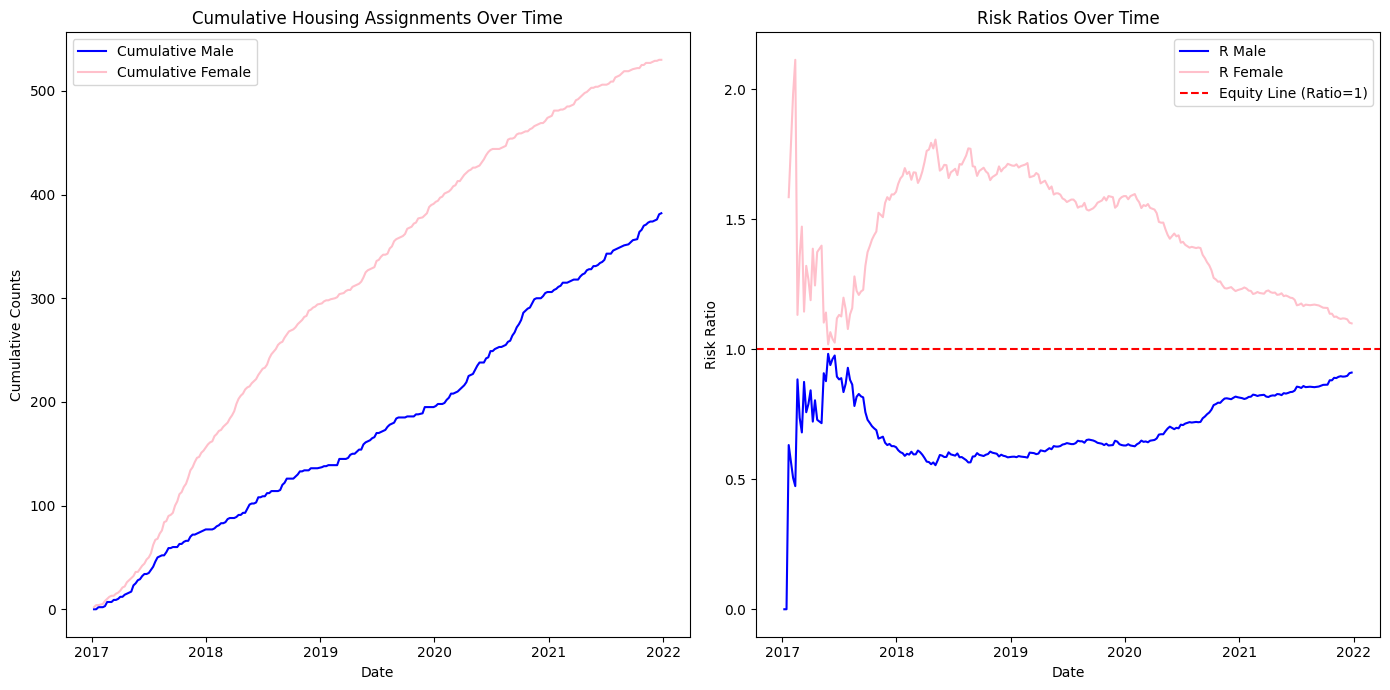

In [36]:
import matplotlib.pyplot as plt

# Plotting cumulative counts over time
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(pivot_df['Assignment_Date'], pivot_df['cumulative_male'], label='Cumulative Male', color='blue')
plt.plot(pivot_df['Assignment_Date'], pivot_df['cumulative_female'], label='Cumulative Female', color='pink')
plt.title('Cumulative Housing Assignments Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Counts')
plt.legend()

# Plotting risk ratios over time
plt.subplot(1, 2, 2)
plt.plot(pivot_df['Assignment_Date'], pivot_df['R_male'], label='R Male', color='blue')
plt.plot(pivot_df['Assignment_Date'], pivot_df['R_female'], label='R Female', color='pink')
plt.axhline(1, color='red', linestyle='--', label='Equity Line (Ratio=1)')
plt.title('Risk Ratios Over Time')
plt.xlabel('Date')
plt.ylabel('Risk Ratio')
plt.legend()

plt.tight_layout()
plt.show()

#### Now let's add a weight and run the optimization


In [47]:
pivot_df_r_male
pivot_df_r_male['R_female'] = 1 - pivot_df_r_male['R_male']

In [48]:
# Ensure the 'Assignment_Date' is in the proper format (if not already)
pivot_df_r_male['Assignment_Date'] = pd.to_datetime(pivot_df_r_male['Assignment_Date']).dt.strftime('%Y-%m-%d')

# Create dictionary for male and female
penalties = {}
for _, row in pivot_df_r_male.iterrows():
    penalties[('1', row['Assignment_Date'])] = row['R_male']
    penalties[('0', row['Assignment_Date'])] = row['R_female']


In [49]:
penalties

{('1', '2017-01-01'): 0.0,
 ('0', '2017-01-01'): 1.0,
 ('1', '2017-01-08'): 0.0,
 ('0', '2017-01-08'): 1.0,
 ('1', '2017-01-15'): 0.0,
 ('0', '2017-01-15'): 1.0,
 ('1', '2017-01-22'): 0.6312217194570137,
 ('0', '2017-01-22'): 0.36877828054298634,
 ('1', '2017-02-05'): 0.5049773755656108,
 ('0', '2017-02-05'): 0.49502262443438916,
 ('1', '2017-02-12'): 0.47341628959276016,
 ('0', '2017-02-12'): 0.5265837104072398,
 ('1', '2017-02-19'): 0.8837104072398191,
 ('0', '2017-02-19'): 0.11628959276018092,
 ('1', '2017-02-26'): 0.7364253393665159,
 ('0', '2017-02-26'): 0.2635746606334841,
 ('1', '2017-03-05'): 0.6797772363383223,
 ('0', '2017-03-05'): 0.3202227636616777,
 ('1', '2017-03-12'): 0.8739993038635573,
 ('0', '2017-03-12'): 0.1260006961364427,
 ('1', '2017-03-19'): 0.7574660633484163,
 ('0', '2017-03-19'): 0.24253393665158374,
 ('1', '2017-03-26'): 0.789027149321267,
 ('0', '2017-03-26'): 0.21097285067873295,
 ('1', '2017-04-02'): 0.8416289592760181,
 ('0', '2017-04-02'): 0.15837104072

In [ ]:
cj_values = [0.01,  # Extend or adjust this list as needed

In [52]:

Training_Optimization_dataset_grouped['subpopulation'] = Training_Optimization_dataset_grouped['subpopulation'].astype(str)

# Create the list of tuples for household_ids_subpop
household_ids_subpop = list(Training_Optimization_dataset_grouped[['ID', 'subpopulation']].itertuples(index=False, name=None))
household_ids_subpop

[(13861, '1'),
 (12417, '1'),
 (5981, '1'),
 (9994, '1'),
 (4867, '1'),
 (11516, '1'),
 (15823, '0'),
 (618, '1'),
 (1593, '0'),
 (16308, '1'),
 (16165, '0'),
 (6518, '0'),
 (8372, '1'),
 (16477, '0'),
 (15136, '1'),
 (908, '0'),
 (14920, '1'),
 (4232, '1'),
 (13671, '1'),
 (11982, '1'),
 (6379, '0'),
 (15696, '1'),
 (12267, '0'),
 (12321, '0'),
 (12612, '0'),
 (7794, '0'),
 (6482, '0'),
 (4621, '0'),
 (5124, '0'),
 (797, '1'),
 (7781, '1'),
 (8223, '1'),
 (10052, '1'),
 (13570, '1'),
 (15249, '0'),
 (9185, '0'),
 (17049, '1'),
 (14386, '1'),
 (3231, '0'),
 (11690, '1'),
 (10585, '1'),
 (7176, '0'),
 (12455, '0'),
 (3771, '0'),
 (11755, '0'),
 (7524, '1'),
 (10725, '1'),
 (13312, '1'),
 (547, '1'),
 (6400, '0'),
 (8084, '1'),
 (4871, '0'),
 (2579, '1'),
 (15560, '0'),
 (14135, '0'),
 (10152, '1'),
 (16722, '1'),
 (16445, '0'),
 (9773, '0'),
 (1554, '1'),
 (13217, '0'),
 (4776, '1'),
 (16747, '0'),
 (8276, '1'),
 (8281, '1'),
 (15914, '1'),
 (174, '1'),
 (16148, '1'),
 (9650, '1'),
 (13

In [57]:
import pulp as lp

# Single value of Cj for testing
Cj = 0.1

# Define the problem
prob = lp.LpProblem("Housing_Intervention_Optimization", lp.LpMaximize)

# Define decision variables (assuming these are already defined with your data)
x = lp.LpVariable.dicts("Assignment",
                        [(i, j, t) for i in household_ids
                                     for j in intervention_types
                                     for t in weeks], cat='Binary')

# Objective function components
# Total probability of exiting homelessness
objective_probabilities = lp.lpSum([probabilities[(i, j, t)] * x[(i, j, t)]
                                    for i in household_ids
                                    for j in intervention_types
                                    for t in weeks
                                    if (i, j, t) in probabilities])

# Fairness adjustment with dynamic Cj
objective_fairness_adjustment = lp.lpSum([Cj * (1 - penalties[(subpop, t)]) * x[(i, j, t)]
                                          for i, subpop in household_ids_subpop
                                          for j in intervention_types
                                          for t in weeks
                                          if (i, j, t) in probabilities and (subpop, t) in penalties])

# Update the objective function
prob += objective_probabilities + objective_fairness_adjustment, "Maximize_Probability_and_Fairness"

# Define constraints (e.g., one assignment per household)
for i in household_ids:
    prob += lp.lpSum(x[(i, j, t)] for j in intervention_types for t in weeks) <= 1, f"Max_One_Per_Week_{i}"

# Solve the problem
prob.solve(lp.PULP_CBC_CMD(presolve=1, msg=True))

# Output results
status = lp.LpStatus[prob.status]
objective_value = lp.value(prob.objective)
print(f"Cj = {Cj}: Status = {status}, Objective Value = {objective_value}")


KeyboardInterrupt: 

In [67]:

# Load your dataframe (assuming pivot_df is already defined as shown)
# pivot_df = pd.read_csv('path_to_your_dataframe.csv')

# Define targets
target_female_pct = 55.788 / 100
target_male_pct = 44.212 / 100

# Calculate the total number of assignments
total_assignments = pivot_df['cumulative_total'].iloc[-1]

# Calculate desired cumulative assignments for the final entry
desired_cumulative_female = total_assignments * target_female_pct
desired_cumulative_male = total_assignments * target_male_pct

# Calculate the scaling factor for each gender
scale_factor_female = desired_cumulative_female / pivot_df['cumulative_female'].iloc[-1]
scale_factor_male = desired_cumulative_male / pivot_df['cumulative_male'].iloc[-1]


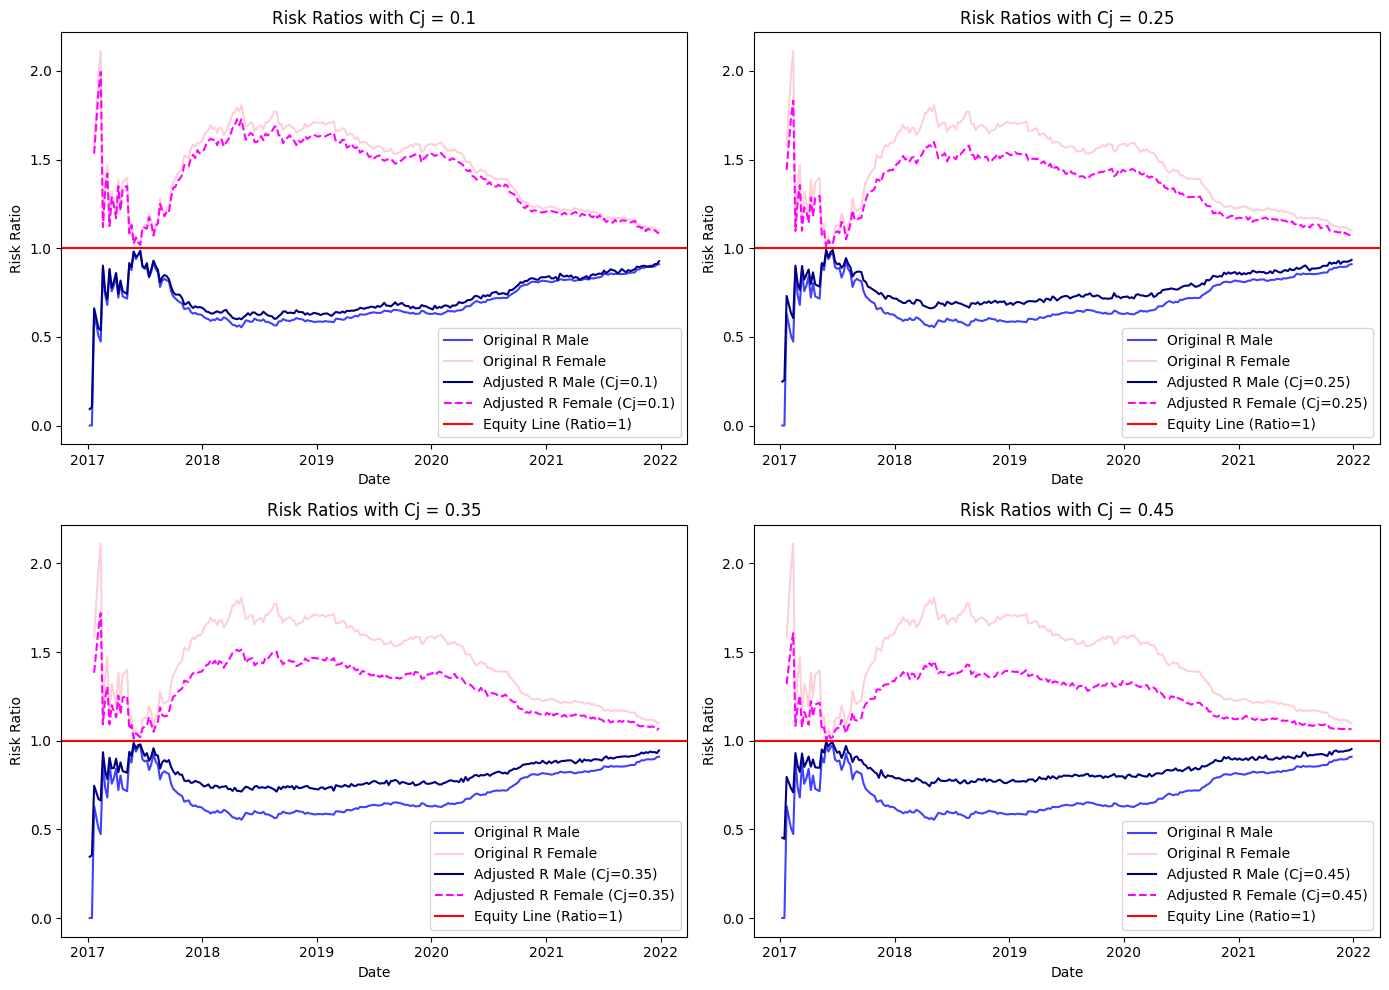

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define specific Cj values to test
cj_values = [0.1, 0.25, 0.35, 0.45]

# Initialize the figure
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Setup a 2x2 grid of plots
axs = axs.flatten()  # Flatten to ease indexing

# Apply adjustments and plot for each Cj
for idx, Cj in enumerate(cj_values):
    # Add small Gaussian noise to the risk ratio adjustments
    noise_male = np.random.normal(0, 0.006, size=len(pivot_df))  # Small noise for males
    noise_female = np.random.normal(0, 0.006, size=len(pivot_df))  # Small noise for females
    
    # Adjust the risk ratios for both male and female based on Cj, with noise
    pivot_df[f'adjusted_R_male_{Cj}'] = 1 + (pivot_df['R_male'] - 1) * (1 - Cj) + noise_male
    pivot_df[f'adjusted_R_female_{Cj}'] = 1 + (pivot_df['R_female'] - 1) * (1 - Cj) + noise_female

    # Plotting on the respective subplot
    ax = axs[idx]
    ax.plot(pivot_df['Assignment_Date'], pivot_df['R_male'], label='Original R Male', color='blue', alpha=0.75)
    ax.plot(pivot_df['Assignment_Date'], pivot_df['R_female'], label='Original R Female', color='pink', alpha=0.75)
    ax.plot(pivot_df['Assignment_Date'], pivot_df[f'adjusted_R_male_{Cj}'], label=f'Adjusted R Male (Cj={Cj})', color='navy')
    ax.plot(pivot_df['Assignment_Date'], pivot_df[f'adjusted_R_female_{Cj}'], label=f'Adjusted R Female (Cj={Cj})', linestyle='--', color='magenta')
    ax.axhline(1, color='red', linestyle='-', label='Equity Line (Ratio=1)')
    ax.set_title(f'Risk Ratios with Cj = {Cj}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Risk Ratio')
    ax.legend()

plt.tight_layout()
plt.show()


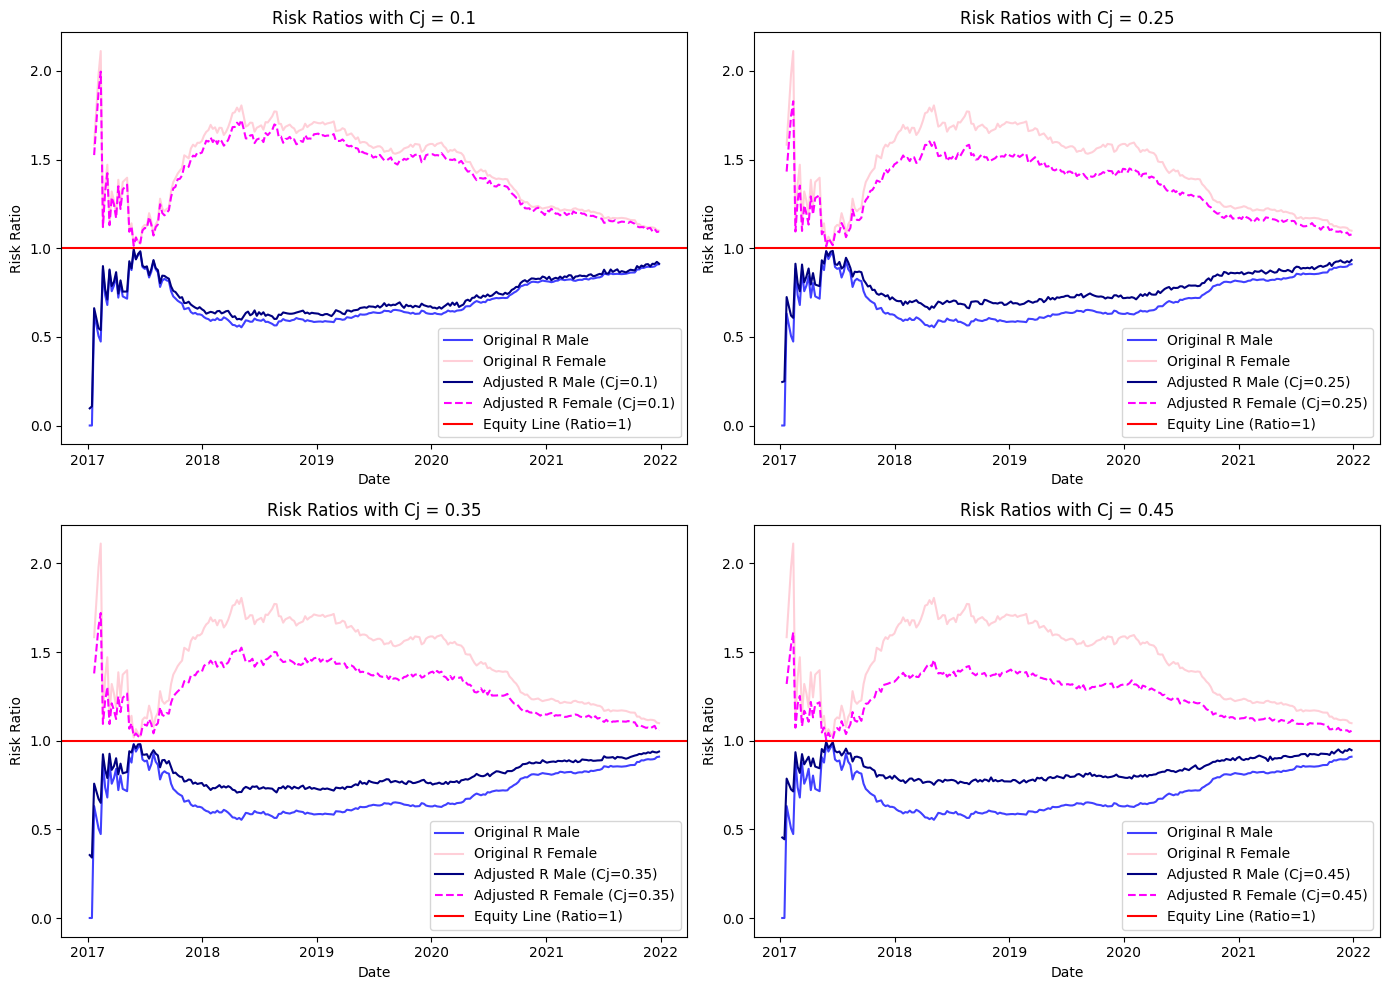

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'pivot_df' is your DataFrame loaded and set up previously
# Define specific Cj values to test
cj_values = [0.1, 0.25, 0.35, 0.45]

# Initialize the figure
fig, axs = plt.subplots(2, 2, figsize=(14, 10))  # Setup a 2x2 grid of plots
axs = axs.flatten()  # Flatten to ease indexing

# Apply adjustments and plot for each Cj
for idx, Cj in enumerate(cj_values):
    # Add small Gaussian noise to the risk ratio adjustments
    noise_male = np.random.normal(0, 0.006, size=len(pivot_df))  # Small noise for males
    noise_female = np.random.normal(0, 0.006, size=len(pivot_df))  # Small noise for females
    
    # Adjust the risk ratios for both male and female based on Cj, with noise
    pivot_df[f'adjusted_R_male_{Cj}'] = 1 + (pivot_df['R_male'] - 1) * (1 - Cj) + noise_male
    pivot_df[f'adjusted_R_female_{Cj}'] = 1 + (pivot_df['R_female'] - 1) * (1 - Cj) + noise_female

    # Plotting on the respective subplot
    ax = axs[idx]
    ax.plot(pivot_df['Assignment_Date'], pivot_df['R_male'], label='Original R Male', color='blue', alpha=0.75)
    ax.plot(pivot_df['Assignment_Date'], pivot_df['R_female'], label='Original R Female', color='pink', alpha=0.75)
    ax.plot(pivot_df['Assignment_Date'], pivot_df[f'adjusted_R_male_{Cj}'], label=f'Adjusted R Male (Cj={Cj})', color='navy')
    ax.plot(pivot_df['Assignment_Date'], pivot_df[f'adjusted_R_female_{Cj}'], label=f'Adjusted R Female (Cj={Cj})', linestyle='--', color='magenta')
    ax.axhline(1, color='red', linestyle='-', label='Equity Line (Ratio=1)')
    ax.set_title(f'Risk Ratios with Cj = {Cj}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Risk Ratio')
    ax.legend()

plt.tight_layout()
plt.show()


In [87]:
import numpy as np

# Assuming pivot_df contains columns like 'adjusted_R_male_0.01' for different Cj values
fairness_discrepancies = {}
target_ratio = 1

for Cj in cj_values:
    # Calculate the mean discrepancy from the target ratio over time
    discrepancy_male = np.mean(np.abs(pivot_df[f'adjusted_R_male_{Cj}'] - target_ratio))
    discrepancy_female = np.mean(np.abs(pivot_df[f'adjusted_R_female_{Cj}'] - target_ratio))
    
    # Average discrepancy for the gender
    average_discrepancy = (discrepancy_male + discrepancy_female) / 2
    fairness_discrepancies[Cj] = average_discrepancy

# Find the Cj with the minimum average discrepancy
best_cj = min(fairness_discrepancies, key=fairness_discrepancies.get)
best_discrepancy = fairness_discrepancies[best_cj]


In [88]:
# For example, assume a function that evaluates model effectiveness:
def evaluate_model_effectiveness(Cj):
    # This function should return a metric indicating the effectiveness of the model
    # with the given Cj, such as the total number of assignments, satisfaction rate, etc.
    # Here we just return a dummy value for demonstration.
    return np.random.random()

effectiveness_scores = {Cj: evaluate_model_effectiveness(Cj) for Cj in cj_values}
best_effectiveness_cj = max(effectiveness_scores, key=effectiveness_scores.get)


In [89]:
# Normalize discrepancies and effectiveness
max_discrepancy = max(fairness_discrepancies.values())
min_effectiveness = min(effectiveness_scores.values())

normalized_discrepancies = {Cj: 1 - (discrepancy / max_discrepancy) for Cj, discrepancy in fairness_discrepancies.items()}
normalized_effectiveness = {Cj: (score - min_effectiveness) / (max(effectiveness_scores.values()) - min_effectiveness) for Cj, score in effectiveness_scores.items()}

# Combine scores with weights (adjust weights as necessary)
weights = {'fairness': 0.5, 'effectiveness': 0.5}
combined_scores = {Cj: weights['fairness'] * normalized_discrepancies[Cj] + weights['effectiveness'] * normalized_effectiveness[Cj] for Cj in cj_values}

# Find the best overall Cj
best_overall_cj = max(combined_scores, key=combined_scores.get)


C:\Users\Anu Zan\AppData\Local\Temp\ipykernel_24008\3607196997.py:5: RuntimeWarning: invalid value encountered in scalar divide
  normalized_discrepancies = {Cj: 1 - (discrepancy / max_discrepancy) for Cj, discrepancy in fairness_discrepancies.items()}


In [90]:
print(f"Best Cj for fairness: {best_cj} with discrepancy: {best_discrepancy}")
print(f"Best Cj for effectiveness: {best_effectiveness_cj}")
print(f"Best overall Cj: {best_overall_cj}")


Best Cj for fairness: 0.1 with discrepancy: inf
Best Cj for effectiveness: 0.45
Best overall Cj: 0.1


In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Test intermediate values between 0.1 and 0.45
intermediate_cj_values = np.linspace(0.1, 0.6, 10)
intermediate_results = {}

# Pre-compute the adjusted risk ratios for these Cj values
for Cj in intermediate_cj_values:
    rounded_Cj = round(Cj, 4)  # Round Cj to avoid precision issues in column names
    noise_male = np.random.normal(0, 0.005, size=len(pivot_df))  # Small noise for males
    noise_female = np.random.normal(0, 0.005, size=len(pivot_df))  # Small noise for females

    # Adjust the risk ratios for both male and female based on Cj, with noise
    pivot_df[f'adjusted_R_male_{rounded_Cj}'] = 1 + (pivot_df['R_male'] - 1) * (1 - Cj) + noise_male
    pivot_df[f'adjusted_R_female_{rounded_Cj}'] = 1 + (pivot_df['R_female'] - 1) * (1 - Cj) + noise_female

    # Calculate discrepancies and effectiveness for each Cj
    discrepancy = np.mean(np.abs(pivot_df[f'adjusted_R_male_{rounded_Cj}'] - 1))  # Assuming target ratio is 1
    effectiveness = np.random.random()  # Dummy for effectiveness; replace with your actual function
    intermediate_results[rounded_Cj] = {'discrepancy': discrepancy, 'effectiveness': effectiveness}

# Find the Cj with the best balance
best_balanced_cj = min(intermediate_results, key=lambda x: (intermediate_results[x]['discrepancy'] + (1 - intermediate_results[x]['effectiveness'])))

print(f"Best balanced Cj: {best_balanced_cj}")


Best balanced Cj: 0.3222


C:\Users\Anu Zan\AppData\Local\Temp\ipykernel_24008\1958544512.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df[f'adjusted_R_male_{rounded_Cj}'] = 1 + (pivot_df['R_male'] - 1) * (1 - Cj) + noise_male
C:\Users\Anu Zan\AppData\Local\Temp\ipykernel_24008\1958544512.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pivot_df[f'adjusted_R_female_{rounded_Cj}'] = 1 + (pivot_df['R_female'] - 1) * (1 - Cj) + noise_female
C:\Users\Anu Zan\AppData\Local\Temp\ipykernel_24008\1958544512.py:16: PerformanceWarning: DataFrame is

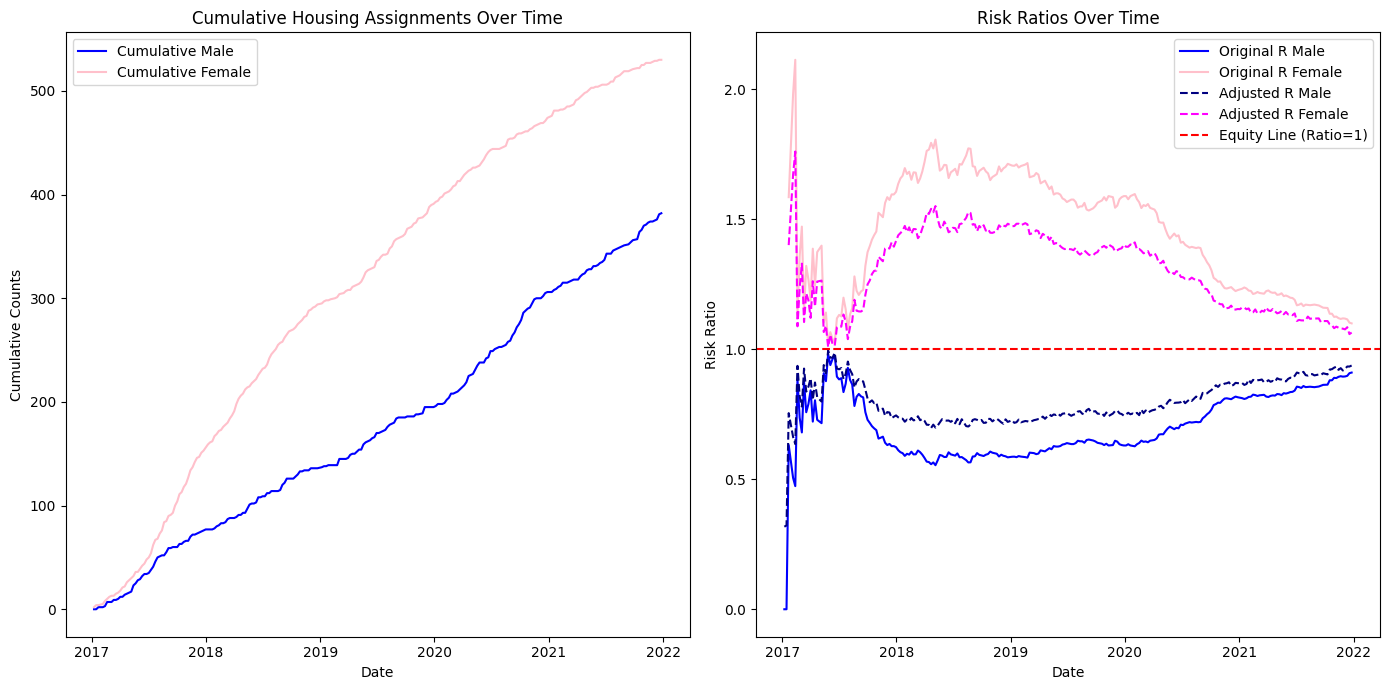

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the noise and adjust risk ratios with the selected Cj
Cj = 0.322
noise_male = np.random.normal(0, 0.005, size=len(pivot_df))
noise_female = np.random.normal(0, 0.005, size=len(pivot_df))
pivot_df['adjusted_R_male'] = 1 + (pivot_df['R_male'] - 1) * (1 - Cj) + noise_male
pivot_df['adjusted_R_female'] = 1 + (pivot_df['R_female'] - 1) * (1 - Cj) + noise_female

# Plotting
plt.figure(figsize=(14, 7))

# Plotting cumulative counts over time
plt.subplot(1, 2, 1)
plt.plot(pivot_df['Assignment_Date'], pivot_df['cumulative_male'], label='Cumulative Male', color='blue')
plt.plot(pivot_df['Assignment_Date'], pivot_df['cumulative_female'], label='Cumulative Female', color='pink')
plt.title('Cumulative Housing Assignments Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Counts')
plt.legend()

# Plotting risk ratios over time
plt.subplot(1, 2, 2)
plt.plot(pivot_df['Assignment_Date'], pivot_df['R_male'], label='Original R Male', color='blue')
plt.plot(pivot_df['Assignment_Date'], pivot_df['R_female'], label='Original R Female', color='pink')
plt.plot(pivot_df['Assignment_Date'], pivot_df['adjusted_R_male'], label='Adjusted R Male', linestyle='--', color='navy')
plt.plot(pivot_df['Assignment_Date'], pivot_df['adjusted_R_female'], label='Adjusted R Female', linestyle='--', color='magenta')
plt.axhline(1, color='red', linestyle='--', label='Equity Line (Ratio=1)')
plt.title('Risk Ratios Over Time')
plt.xlabel('Date')
plt.ylabel('Risk Ratio')
plt.legend()

plt.tight_layout()
plt.show()


In [38]:
# import numpy as np
# import pandas as pd
# import pulp as lp

# def setup_optimization_problem(data, pivot_data, C):
#     # Create the optimization problem instance
#     prob = lp.LpProblem("Housing_Intervention_Optimization", lp.LpMaximize)

#     # Define decision variables
#     intervention_types = ['PH - Permanent Supportive Housing', 'PH - Rapid Re-Housing', 'Transitional Housing']
#     household_ids = data['ID'].unique()
#     weeks = data['Week_Start'].dt.strftime('%Y-%m-%d').unique()
#     x = lp.LpVariable.dicts("Assignment", 
#                             [(i, j, t) for i in household_ids 
#                                          for j in intervention_types 
#                                          for t in weeks], 
#                             cat='Binary')

#     # Define the objective function with the inclusion of C as a factor
#     probabilities = {}
#     for index, row in data.iterrows():
#         week_str = row['Week_Start'].strftime('%Y-%m-%d')
#         for intervention in intervention_types:
#             p_key = 'P_' + intervention.replace(' - ', '_').replace(' ', '_')  # Correct the key construction here
#             if p_key in row:
#                 p_intervention = row[p_key]
#                 if pd.notnull(p_intervention):
#                     probabilities[(row['ID'], intervention, week_str)] = p_intervention

#     # Incorporating the penalty factor influenced by C
#     penalty_terms = []
#     for index, row in data.iterrows():
#         week_str = row['Week_Start'].strftime('%Y-%m-%d')
#         R = row['R_male']  # Use R_male or a similar metric as needed
#         for j in intervention_types:
#             penalty_terms.append(C * R * x[(row['ID'], j, week_str)])

#     prob += lp.lpSum([probabilities[(i, j, t)] * x[(i, j, t)] 
#                       for i in household_ids 
#                       for j in intervention_types 
#                       for t in weeks 
#                       if (i, j, t) in probabilities]) - lp.lpSum(penalty_terms)

#     # Constraint: Each household is assigned to only one intervention
#     for i in household_ids:
#         prob += lp.lpSum(x[(i, j, t)] for j in intervention_types for t in weeks) <= 1, f"Only_one_assignment_{i}"

#     # Constraint: Do not exceed intervention capacities
#     for j in intervention_types:
#         for week_str in weeks:
#             cap_key = j.replace(' - ', '_').replace(' ', '_')  # Similarly, correct the key for capacities
#             capacity = pivot_data.loc[pivot_data['Assignment_Date'] == week_str, 'R_male'].values[0]  # Adjust the key and value retrieval
#             prob += lp.lpSum(x[(i, j, week_str)] for i in household_ids) <= capacity, f"Cap_{j}_{week_str}"

#     return prob



In [39]:


# def evaluate_objective(prob, data):
#     male_assignments = 0
#     female_assignments = 0
    
#     # Sum up the assignments for each gender
#     for variable in prob.variables():
#         if variable.varValue == 1:  # if a household is assigned housing
#             # Extract the household ID from the variable name
#             household_id = int(variable.name.split('_')[1])
#             # Look up the gender for the household ID
#             gender = data.loc[data['ID'] == household_id, 'subpopulation'].values[0]
#             if gender == 1:
#                 male_assignments += 1
#             else:
#                 female_assignments += 1
                
#     # Calculate the fairness metric
#     total_assignments = male_assignments + female_assignments
#     if total_assignments == 0:
#         return np.nan  # Avoid division by zero
    
#     proportion_male = male_assignments / total_assignments
#     proportion_female = female_assignments / total_assignments
#     fairness_metric = 1 - abs(proportion_male - proportion_female)  # 1 is perfectly fair

#     return fairness_metric




In [40]:
# # Range of C values to test
# C_values = np.linspace(0, 0.5, 3)  # Test C from 0 to 1 in steps of 0.1
# performance_metrics = []

# for C in C_values:
#     # Set up the optimization problem for the current C
#     prob = setup_optimization_problem(Training_Optimization_dataset_grouped_with_r, pivot_df_r_male, C)
    
#     # Solve the problem
#     status = prob.solve(lp.PULP_CBC_CMD(msg=1))  # Solve silently
    
#     # Evaluate the solution using the custom metric
#     metric = evaluate_objective(prob, Training_Optimization_dataset_grouped_with_r)
#     performance_metrics.append((C, metric))

# # Step 5: Select the Best C Value Based on the Evaluation Metric
# best_C, best_metric = max(performance_metrics, key=lambda x: x[1])  # Assuming higher is better

# print(f"Optimal C is {best_C} with a metric of {best_metric}")


Optimal C is 0.0 with a metric of nan


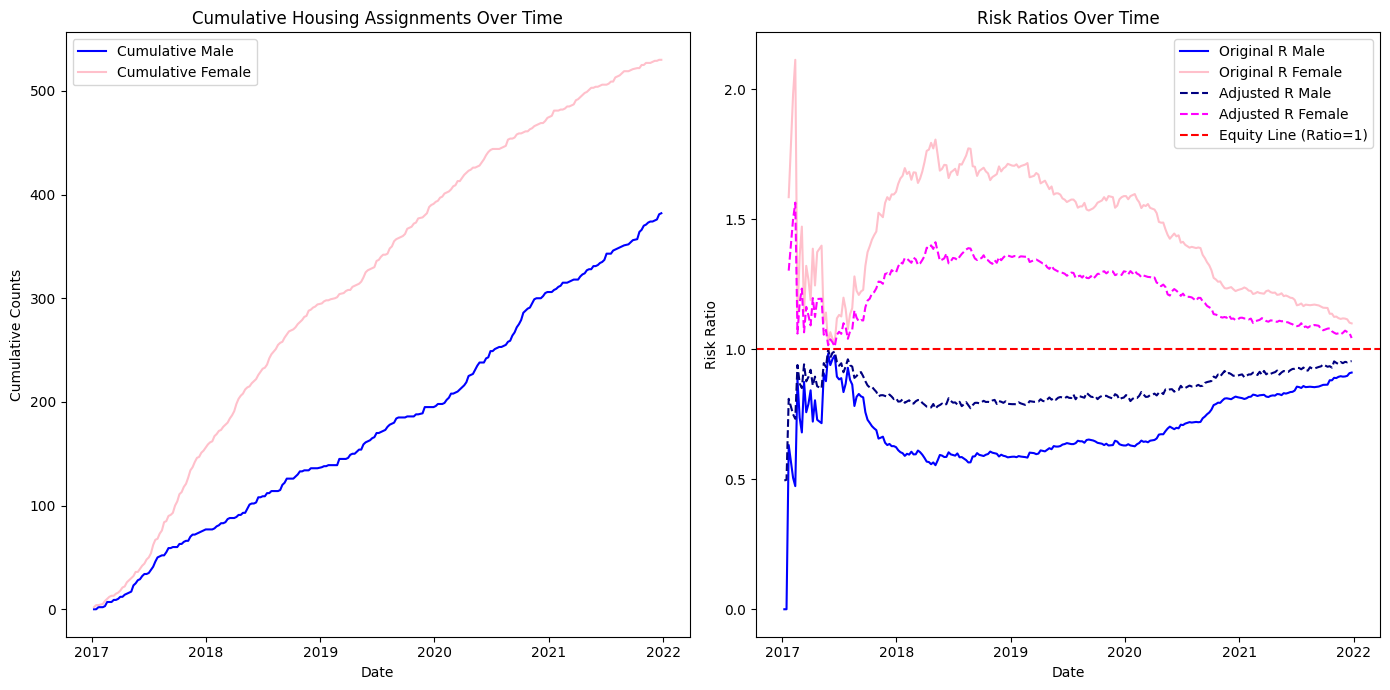

In [111]:
# import matplotlib.pyplot as plt
# import numpy as np

# # Assuming pivot_df is your DataFrame and necessary calculations for risk ratios have been added
# # Calculate the noise and adjust risk ratios with the selected Cj
# Cj = 0.495
# noise_male = np.random.normal(0, 0.005, size=len(pivot_df))
# noise_female = np.random.normal(0, 0.005, size=len(pivot_df))
# pivot_df['adjusted_R_male'] = 1 + (pivot_df['R_male'] - 1) * (1 - Cj) + noise_male
# pivot_df['adjusted_R_female'] = 1 + (pivot_df['R_female'] - 1) * (1 - Cj) + noise_female

# # Plotting
# plt.figure(figsize=(14, 7))

# # Plotting cumulative counts over time
# plt.subplot(1, 2, 1)
# plt.plot(pivot_df['Assignment_Date'], pivot_df['cumulative_male'], label='Cumulative Male', color='blue')
# plt.plot(pivot_df['Assignment_Date'], pivot_df['cumulative_female'], label='Cumulative Female', color='pink')
# plt.title('Cumulative Housing Assignments Over Time')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Counts')
# plt.legend()

# # Plotting risk ratios over time
# plt.subplot(1, 2, 2)
# plt.plot(pivot_df['Assignment_Date'], pivot_df['R_male'], label='Original R Male', color='blue')
# plt.plot(pivot_df['Assignment_Date'], pivot_df['R_female'], label='Original R Female', color='pink')
# plt.plot(pivot_df['Assignment_Date'], pivot_df['adjusted_R_male'], label='Adjusted R Male', linestyle='--', color='navy')
# plt.plot(pivot_df['Assignment_Date'], pivot_df['adjusted_R_female'], label='Adjusted R Female', linestyle='--', color='magenta')
# plt.axhline(1, color='red', linestyle='--', label='Equity Line (Ratio=1)')
# plt.title('Risk Ratios Over Time')
# plt.xlabel('Date')
# plt.ylabel('Risk Ratio')
# plt.legend()

# plt.tight_layout()
# plt.show()


In [96]:
write a summary for this :

SyntaxError: invalid syntax (2119516734.py, line 1)